In [128]:
# import libraries 
import pandas as pd # Import Pandas for data manipulation using dataframes
import numpy as np # Import Numpy for data statistical analysis 
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline
sns.set_style("whitegrid")

In [129]:
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [130]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Available GPUs: {gpus}")
    # Optionally, you can limit TensorFlow to use only a specific GPU:
    # tf.config.set_visible_devices(gpus[0], 'GPU')  # Use only the first GPU (index 0)
    
    # Enable memory growth to avoid memory allocation issues
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU detected, using CPU.")

No GPU detected, using CPU.


In [131]:
label_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [132]:
fashion_train_df = pd.read_csv('./fashion-mnist_train.csv')
fashion_test_df = pd.read_csv('./fashion-mnist_test.csv')

print("Training Data Preview:")
print(fashion_train_df.head()) 

print("\nTesting Data Preview:")
print(fashion_test_df.head())

Training Data Preview:
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0      

In [133]:
# Check for missing values in the training and testing datasets
print("\nChecking for missing values in training data:")
print(fashion_train_df.isnull().sum())

print("\nChecking for missing values in testing data:")
print(fashion_test_df.isnull().sum())

# If there are missing values, handle them (example: fill with mean or drop rows)
if fashion_train_df.isnull().values.any():
    print("\nHandling missing values in training data...")
    fashion_train_df.fillna(fashion_train_df.mean(), inplace=True)  # Filling missing values with column mean

if fashion_test_df.isnull().values.any():
    print("\nHandling missing values in testing data...")
    fashion_test_df.fillna(fashion_test_df.mean(), inplace=True)  # Filling missing values with column mean


Checking for missing values in training data:
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

Checking for missing values in testing data:
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64


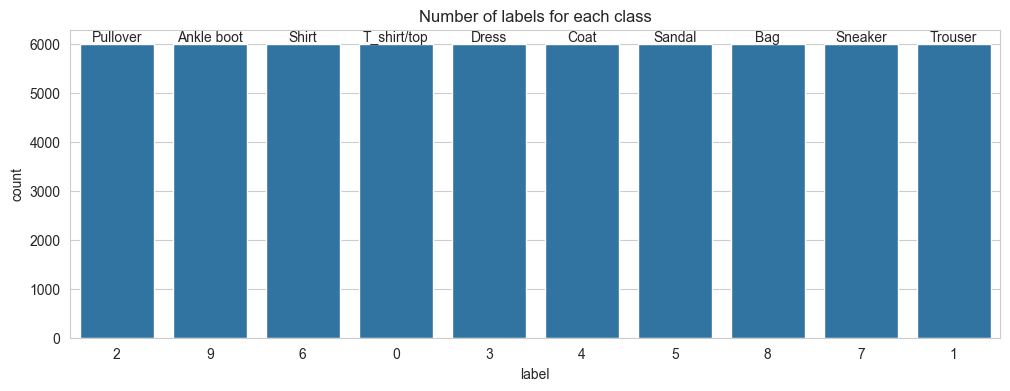

In [134]:

def plot_label_per_class(data, class_names):
    f, ax = plt.subplots(1, 1, figsize=(12, 4))
    
    # Plot the countplot with the correct column reference
    g = sns.countplot(x='label', data=data, order=data['label'].value_counts().index)
    g.set_title("Number of labels for each class")

    # Annotate the bars with class names
    for p, label in zip(g.patches, data['label'].value_counts().index):
        g.annotate(class_names[label], (p.get_x() + p.get_width() / 2, p.get_height() + 0.1),
                   ha='center', va='bottom')

    plt.show()

# Ensure you have a dictionary `class_names` where the keys are the label indices and the values are the corresponding class names
# Example:
# class_names = {0: "T-shirt", 1: "Trouser", 2: "Pullover", ...}

# Call the function with your dataframe and class_names dictionary
plot_label_per_class(fashion_train_df, class_names)


In [135]:
train = np.array(fashion_train_df, dtype='float32')
test = np.array(fashion_test_df, dtype='float32')

In [136]:
train.shape

(60000, 785)

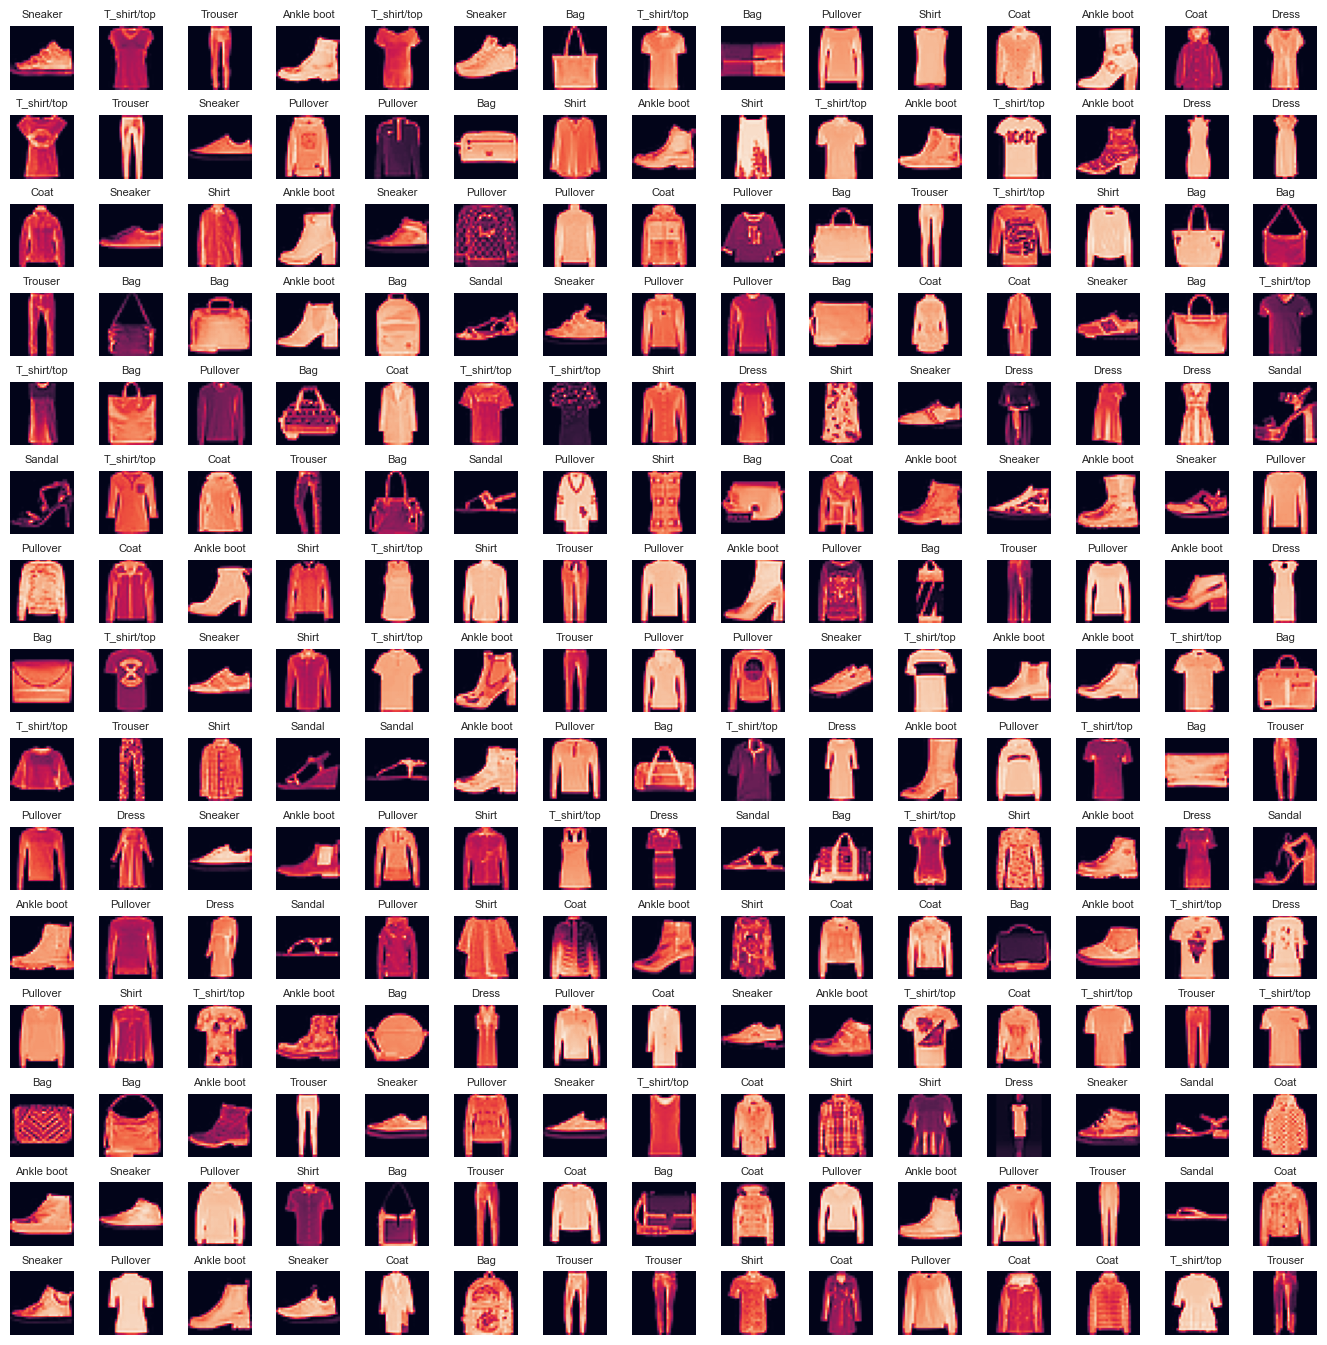

In [137]:
# Define the dimensions of the plot grid 
W_grid = 15
L_grid = 15

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize=(17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow( train[index,1:].reshape((28,28)) )
    label_index = int(train[index,0])
    axes[i].set_title(class_names[label_index], fontsize=8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [138]:
# Prepare the training and testing dataset 
X_train = train[:, 1:] / 255
y_train = train[:, 0]

X_test = test[:, 1:] / 255
y_test = test[:,0]

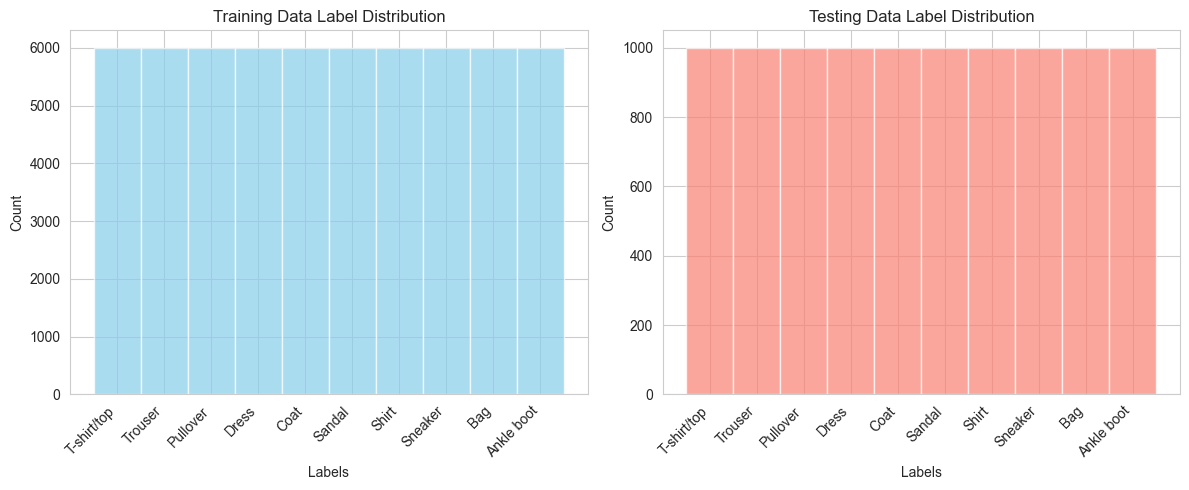

In [139]:
label_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Replace numeric labels with string labels using list comprehension
y_train_full_mapped = np.array([label_mapping[int(label)] for label in y_train])
y_test_mapped = np.array([label_mapping[int(label)] for label in y_test])

# Visualize the label distribution in the training and testing datasets
plt.figure(figsize=(12, 5))

# Training data label distribution
plt.subplot(1, 2, 1)
plt.hist(y_train_full_mapped, bins=np.arange(len(label_mapping) + 1) - 0.5, color='skyblue', alpha=0.7)
plt.title("Training Data Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(np.arange(len(label_mapping)), list(label_mapping.values()), rotation=45, ha='right')

# Testing data label distribution
plt.subplot(1, 2, 2)
plt.hist(y_test_mapped, bins=np.arange(len(label_mapping) + 1) - 0.5, color='salmon', alpha=0.7)
plt.title("Testing Data Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(np.arange(len(label_mapping)), list(label_mapping.values()), rotation=45, ha='right')

plt.tight_layout()
plt.show()

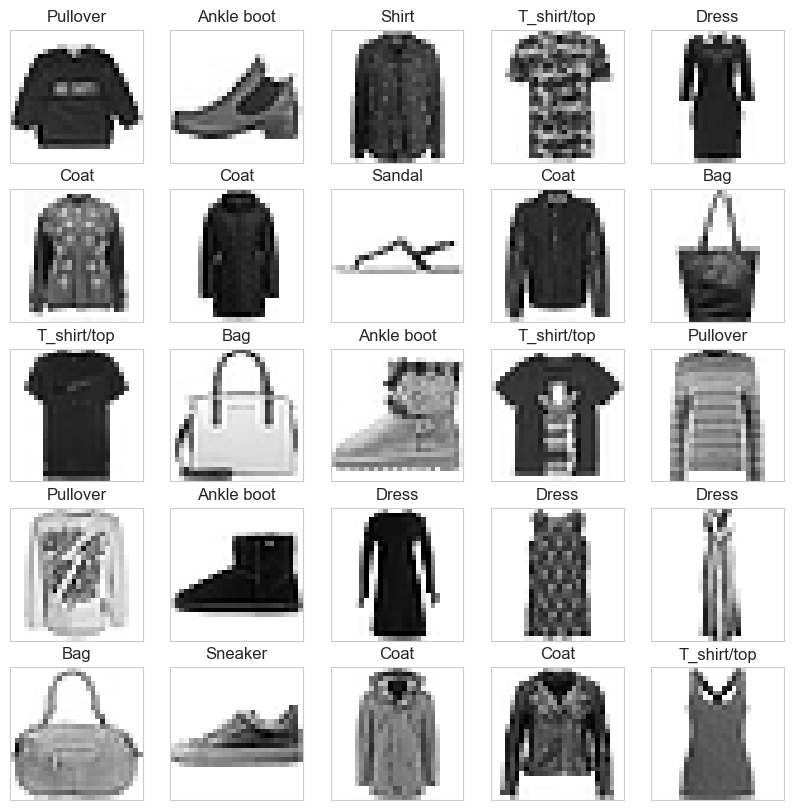

<Figure size 640x480 with 0 Axes>

In [140]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape((28,28)), cmap=plt.cm.binary)
    label_index = int(y_train[i])
    plt.title(class_names[label_index])
plt.show()
plt.tight_layout()

Text(0.5, 1.0, 'Class distribution in testing set')

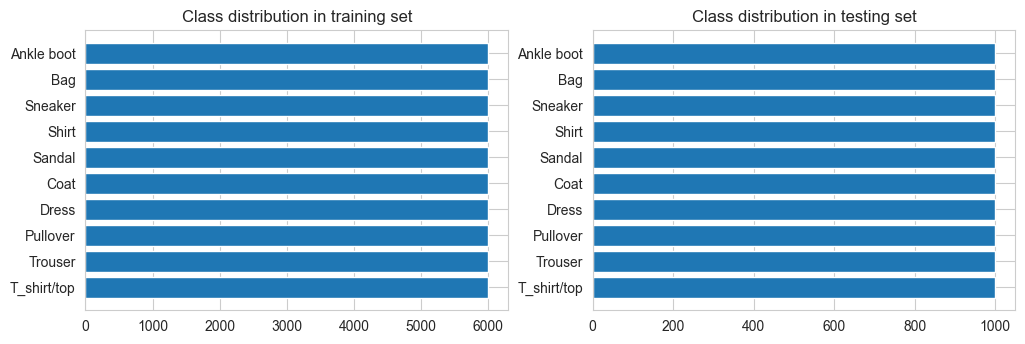

In [141]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
classes, counts = np.unique(y_train, return_counts=True)
plt.barh(class_names, counts)
plt.title('Class distribution in training set')

plt.subplot(2, 2, 2)
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(class_names, counts)
plt.title('Class distribution in testing set')

In [142]:
from sklearn.model_selection import train_test_split

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [143]:
# * unpack the tuple
X_train = X_train.reshape(X_train.shape[0], * (28, 28, 1))
X_test = X_test.reshape(X_test.shape[0], * (28, 28, 1))
X_validate = X_validate.reshape(X_validate.shape[0], * (28, 28, 1))

In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import keras
import tensorflow as tf

In [146]:
cnn_model = Sequential()

# Try 32 fliters first then 64
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28,28,1), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28,28,1), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(28,28,1), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(28,28,1), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))

# cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(28,28,1), activation='relu'))
# cnn_model.add(BatchNormalization())
# cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(28,28,1), activation='relu'))
# cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
# cnn_model.add(Dropout(0.25))

# cnn_model.add(Conv2D(32,3, 3, activation='relu'))
# cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(units=10, activation='softmax'))

In [147]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer='adam' ,metrics=['accuracy'])

In [148]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,586 (1.79 MB)

 Trainable params: 468,202 (1.79 MB)

 Non-trainable params: 384 (1.50 KB)

In [149]:
epochs = 50
batch_size = 512

# early_stopping = EarlyStopping(
#     monitor='val_accuracy',  # Monitor validation accuracy
#     patience=5,              # Stop if no improvement in validation accuracy for 5 epochs
#     verbose=1,               # Show messages when stopping
#     restore_best_weights=True  # Restore the best weights (i.e., the weights from the epoch with the best validation accuracy)
# )

history = cnn_model.fit(
    X_train, y_train, 
    batch_size=batch_size, 
    epochs=epochs,
    verbose=1, 
    validation_data=(X_validate, y_validate),
    # callbacks=[early_stopping]  # Pass the early stopping callback here
)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 301ms/step - accuracy: 0.6948 - loss: 1.0047 - val_accuracy: 0.2553 - val_loss: 2.4342
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 303ms/step - accuracy: 0.8638 - loss: 0.3669 - val_accuracy: 0.1627 - val_loss: 3.6474
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 298ms/step - accuracy: 0.8876 - loss: 0.3041 - val_accuracy: 0.1423 - val_loss: 4.5806
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 297ms/step - accuracy: 0.9062 - loss: 0.2584 - val_accuracy: 0.2334 - val_loss: 5.2277
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 301ms/step - accuracy: 0.9132 - loss: 0.2336 - val_accuracy: 0.4757 - val_loss: 2.4370
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 299ms/step - accuracy: 0.9192 - loss: 0.2176 - val_accuracy: 0.7068 - val_loss: 1.0690
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 298ms/step - accuracy: 0.9279 - loss: 0.1995 - val_accuracy: 0.8366 - val_loss: 0.4745
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 299ms/step - accuracy: 0.9292 - loss: 0.1896 - val_accu

In [150]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9428 - loss: 0.2792
Test Loss: 0.2674517035484314
Test Accuracy: 0.9423999786376953


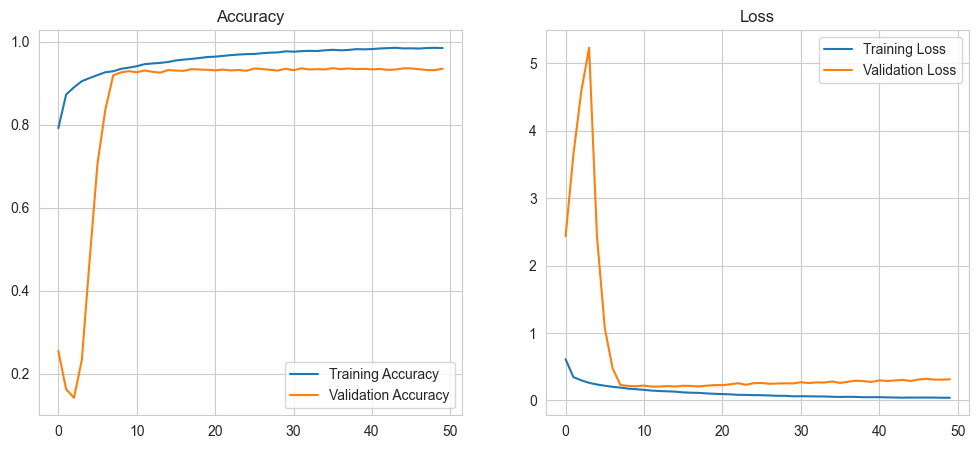

In [151]:
# Visualize accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [152]:
# get the predictions for the test data
predicted_classes = cnn_model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [153]:
test_img = X_test[0]
prediction = cnn_model.predict(X_test)
prediction[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


array([1.00000000e+00, 1.06578385e-20, 4.43674568e-12, 1.54601321e-13,
       1.70263390e-16, 5.18626166e-19, 1.11935927e-08, 2.12098681e-21,
       1.81926139e-15, 2.36680567e-16], dtype=float32)

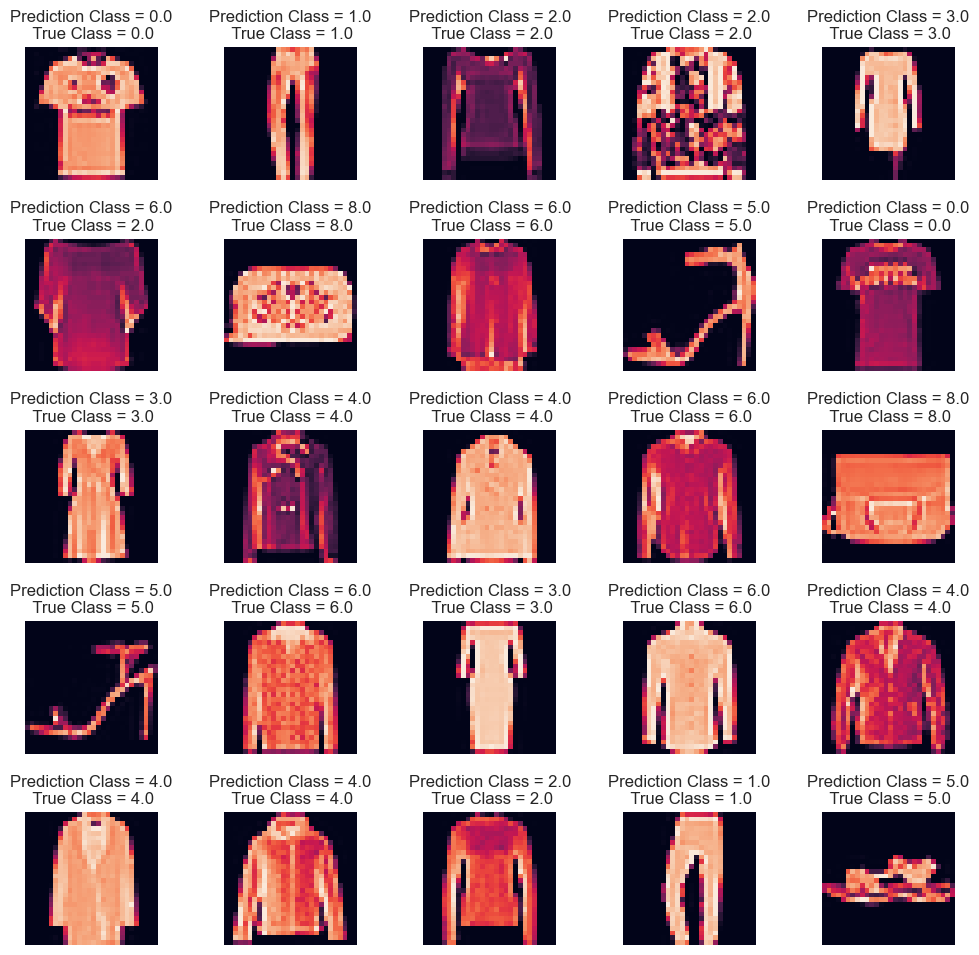

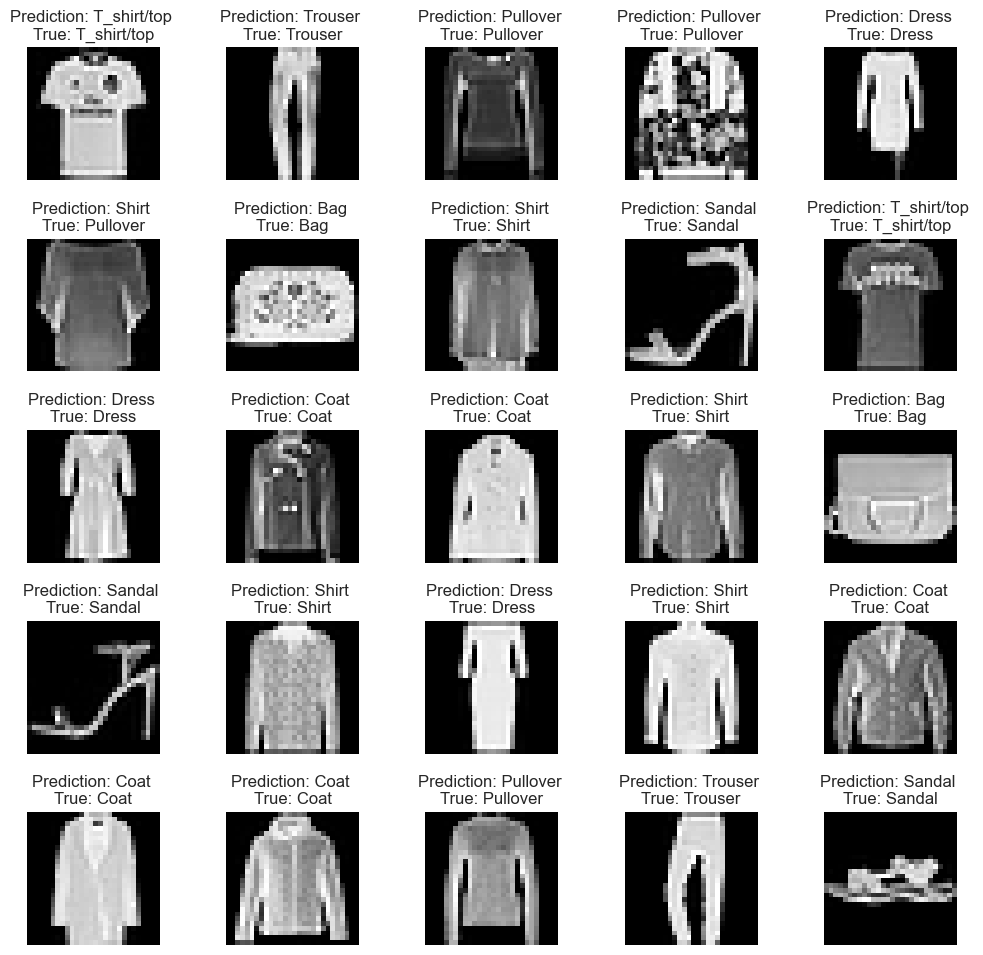

In [154]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i].reshape(28,28))
    axes[i].set_title(f"Prediction Class = {(predicted_classes[i]):0.1f}\n True Class = {y_test[i]:0.1f}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize=(12,12))
axes = axes.ravel()

# Assuming class_names is a list of class labels
# For example: class_names = ['Class 0', 'Class 1', ..., 'Class N']

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Prediction: {class_names[int(predicted_classes[i])]} \nTrue: {class_names[int(y_test[i])]}")  # Use class_names
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)


Confusion Matrix:
 [[893   1  20  16   4   0  64   0   2   0]
 [  0 989   0   9   1   0   1   0   0   0]
 [ 12   0 925  10  25   0  27   0   1   0]
 [  9   1   4 952  19   0  15   0   0   0]
 [  0   1  23  14 935   0  26   0   1   0]
 [  0   0   0   0   0 980   0  12   1   7]
 [ 84   0  36  28  44   0 805   0   3   0]
 [  0   0   0   0   0   2   0 972   0  26]
 [  1   1   0   1   1   0   2   1 992   1]
 [  0   0   0   0   0   0   0  19   0 981]]
Normalized Confusion Matrix:
 [[0.893 0.001 0.02  0.016 0.004 0.    0.064 0.    0.002 0.   ]
 [0.    0.989 0.    0.009 0.001 0.    0.001 0.    0.    0.   ]
 [0.012 0.    0.925 0.01  0.025 0.    0.027 0.    0.001 0.   ]
 [0.009 0.001 0.004 0.952 0.019 0.    0.015 0.    0.    0.   ]
 [0.    0.001 0.023 0.014 0.935 0.    0.026 0.    0.001 0.   ]
 [0.    0.    0.    0.    0.    0.98  0.    0.012 0.001 0.007]
 [0.084 0.    0.036 0.028 0.044 0.    0.805 0.    0.003 0.   ]
 [0.    0.    0.    0.    0.    0.002 0.    0.972 0.    0.026]
 [0.001 0.001 0.

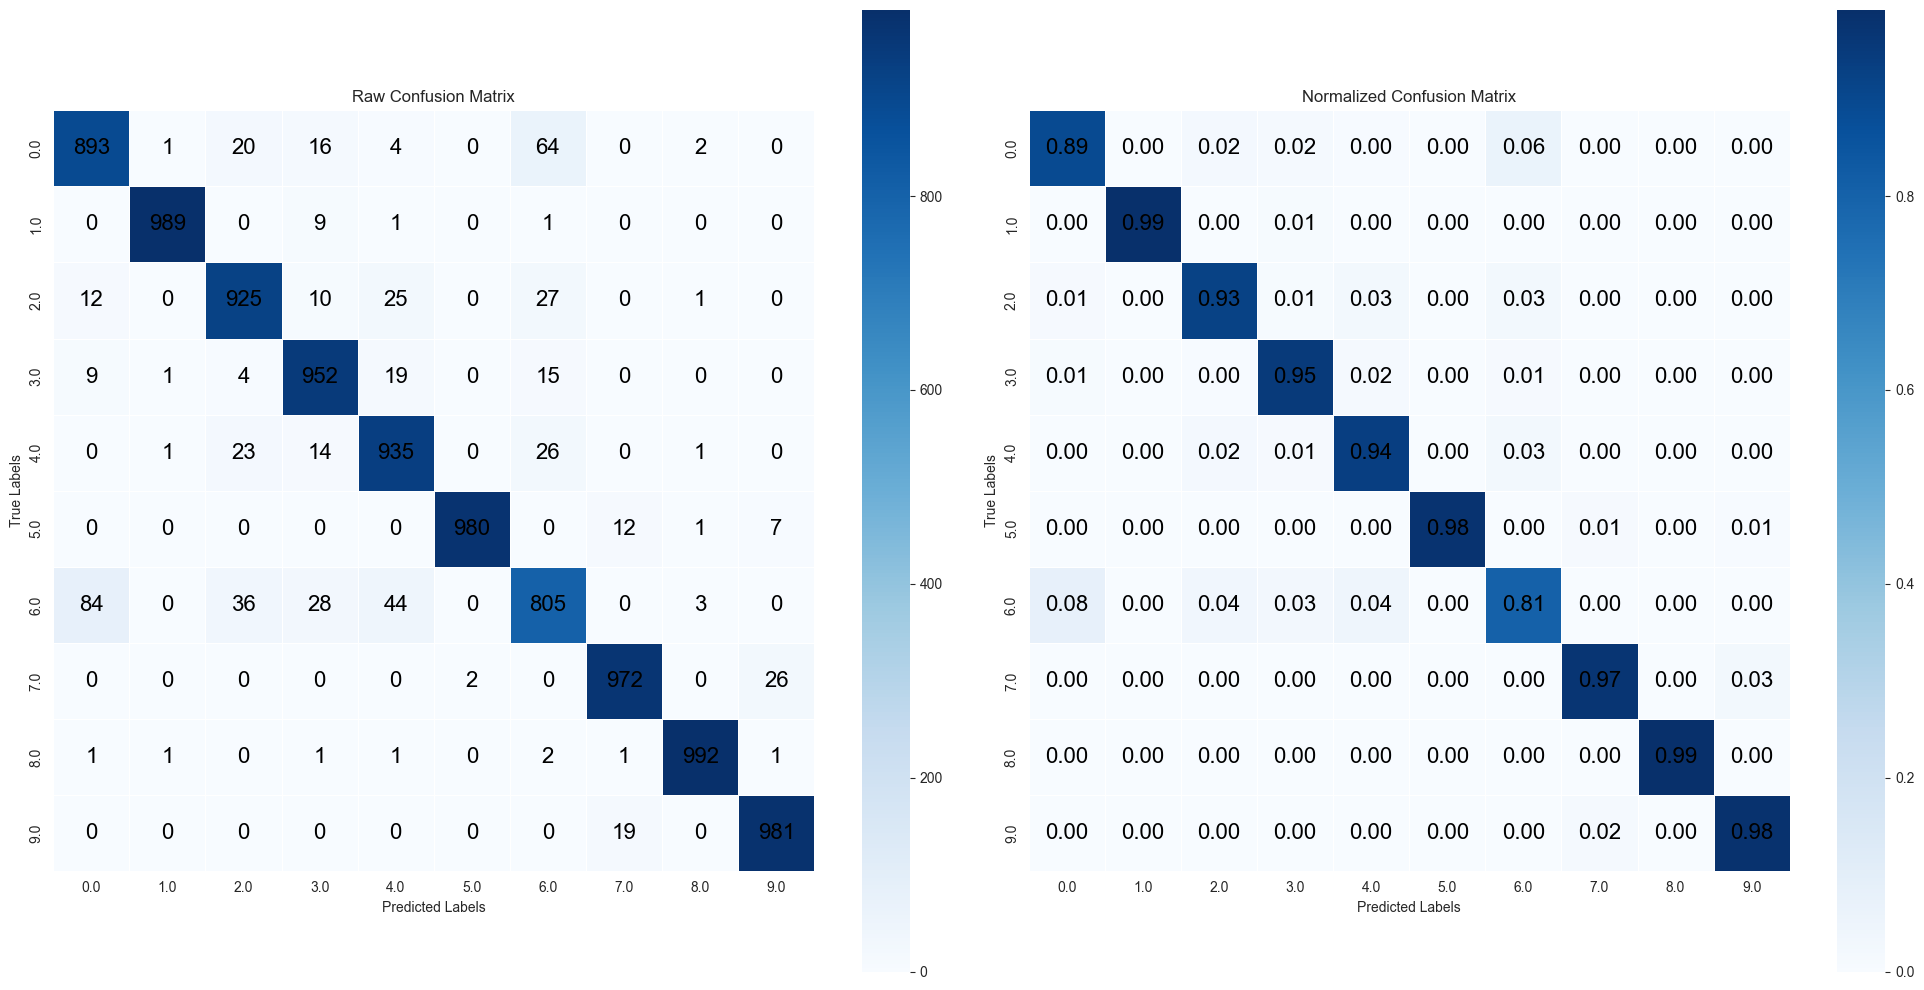

In [155]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and predicted_classes are already defined
# Step 1: Calculate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Step 2: Normalize the confusion matrix if necessary
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Row-wise normalization

# Check the confusion matrix and normalized matrix for debugging
print("Confusion Matrix:\n", cm)
print("Normalized Confusion Matrix:\n", cm_normalized)

# Check dimensions of matrices
print(f"Raw Confusion Matrix shape: {cm.shape}")
print(f"Normalized Confusion Matrix shape: {cm_normalized.shape}")

# Set up the plot with subplots for raw and normalized confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Create two subplots side by side

# Plot the raw confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), 
            ax=axes[0], cbar=True, square=True, linewidths=0.5, annot_kws={'size': 16, 'color': 'black'})
axes[0].set_title('Raw Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), 
            ax=axes[1], cbar=True, square=True, linewidths=0.5, annot_kws={'size': 16, 'color': 'black'})
axes[1].set_title('Normalized Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

# Adjust layout for better display
plt.tight_layout()

# Show the plots
plt.show()


In [156]:
from sklearn.metrics import classification_report

num_classes = 10
target_names = [f"Class {i}" for i in range(num_classes)]

print(classification_report(y_test, predicted_classes, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       0.89      0.89      0.89      1000
     Class 1       1.00      0.99      0.99      1000
     Class 2       0.92      0.93      0.92      1000
     Class 3       0.92      0.95      0.94      1000
     Class 4       0.91      0.94      0.92      1000
     Class 5       1.00      0.98      0.99      1000
     Class 6       0.86      0.81      0.83      1000
     Class 7       0.97      0.97      0.97      1000
     Class 8       0.99      0.99      0.99      1000
     Class 9       0.97      0.98      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

